In [1]:
# this notebook contains the whole pipeline of the proposed model

# Library header
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras import Model, Input
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2
import numpy as np


# import own libraries
from HandSeg.handseg_two_classes import *
from PixelwiseRegression.main import *
from HandSeg.util import *

In [2]:
# initialize the handseg model and load weights
# returns the model object
def initializeHandSeg():
    inputs = Input(shape=(480, 640, 3))
    handseg = Model(inputs=inputs, outputs=handseg_model(inputs), name="HandSeg_Model")

    # build the segmentation model
    handseg.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    # load the weights from previous training
    handseg.load_weights("./HandSeg/weights/handseg_model_twoClasses_4.h5")
    return handseg

In [9]:
# this function will process the whole pipeline of the model
def predictBox(img):
    # ============================= Step 1 =============================
    # load the hand segmentation model
    segmentation_model = initializeHandSeg()
    #reshape input image
    input_image = cv2.resize(img, (640, 480))
    input_image = np.reshape(input_image, (1,480, 640, 3))
    # apply preprocessing
    input_image = preprocess2(input_image)
    # predict hand segmentation
    output_image = segmentation_model.predict(input_image)
    # interpret prediction
    output_image = interpretPrediction(output_image[0])
    # ============================= Step 2 =============================
    # draw the bounding box
    box = drawBoxes(output_image, cv2.resize(img, (640, 480)))
    return box

In [4]:
def cutBox(x, y, width, height, image_name):
    # ============================= Step 3 =============================
    orginial_img = plt.imread(image_name)
    box_image = cv2.resize(orginial_img, (640, 480))
    # cut framed part from image
    box_image = box_image[y:(y+height), x:(x+width)]
    
    xextra = (640-box_image.shape[1]) / 2
    yextra = (480-box_image.shape[0]) / 2
    
    padd_img = np.pad(box_image, (int(xextra), int(yextra)), mode='constant', constant_values=orginial_img[0,0])
    # resize image accordingly
    #plt.imshow(padd_img);plt.title("padded");plt.show()
    result = cv2.resize(padd_img, (320, 240))
    
    return result

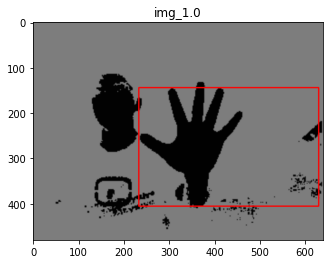

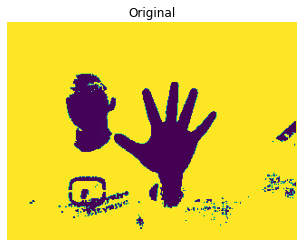

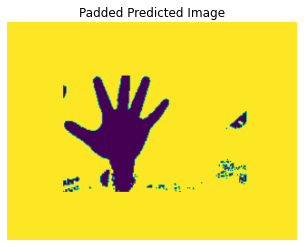

Updated box size,  156
[True, True, True, True, True]
Prediction:  5
Waiting for key to Press: s for saving the images, q for quitting (Press command with images as scene).


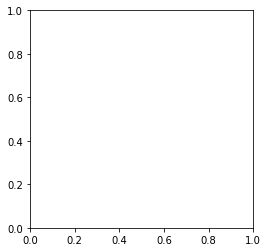

In [37]:
# Main procedure of pipeline
image_name = "../../ICVL/Depth/examples/image_1.png"
img = cv2.imread(image_name)

# predict bounding box via hand segmentation
x, y, width, height = predictBox(img)
predictedImage = cutBox(x, y, width, height, image_name)

plt.imshow(plt.imread(image_name));plt.axis('off');plt.title("Original");plt.show()
plt.imshow(predictedImage);plt.axis('off');plt.title("Padded Predicted Image");plt.show()

# ============================= Step 4&5 ===============================
# predict the hand pose joint coordinates and predict the asl sign
loadModel(predictedImage)